In [ ]:
!pip install kagglehub torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip install torch torchvision kagglehub imbalanced-learn


In [ ]:
import kagglehub
import os
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import Counter
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
dataset_path = kagglehub.dataset_download("cashbowman/ai-generated-images-vs-real-images")


Using device: cuda


IMAGE PREPROCESSING

Class to Index mapping: {'AiArtData': 0, 'RealArt': 1}
Original class distribution: Counter({0: 539, 1: 434})


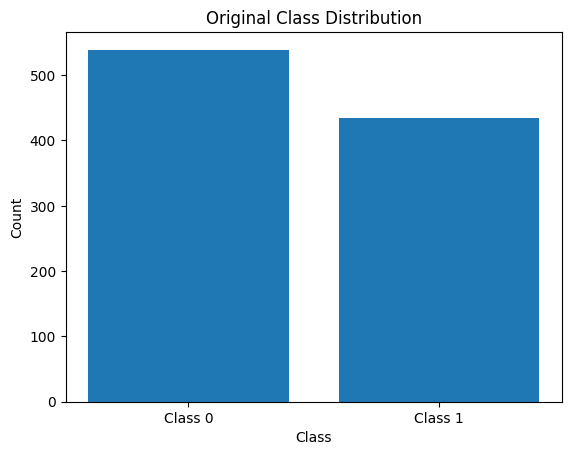

In [ ]:
# define Transforms
image_size = 224
batch_size = 32

# Training transform with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Validation transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

full_dataset = datasets.ImageFolder(root=dataset_path)
print("Class to Index mapping:", full_dataset.class_to_idx)

targets = [label for _, label in full_dataset.imgs]
original_dist = Counter(targets)
print("Original class distribution:", original_dist)

# Visualize original class distribution
def plot_class_distribution(counter_dict, title="Class Distribution"):
    classes = list(counter_dict.keys())
    counts = list(counter_dict.values())
    plt.bar(classes, counts, tick_label=[f"Class {i}" for i in classes])
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

plot_class_distribution(original_dist, "Original Class Distribution")

In [ ]:
#Train/Validation Split (Stratified)
indices = np.arange(len(full_dataset))
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=full_dataset.targets,
    random_state=42
)

train_data = Subset(full_dataset, train_idx)
val_data = Subset(full_dataset, val_idx)


CLASS BALANCING

Balanced class distribution: Counter({1: 431, 0: 431})


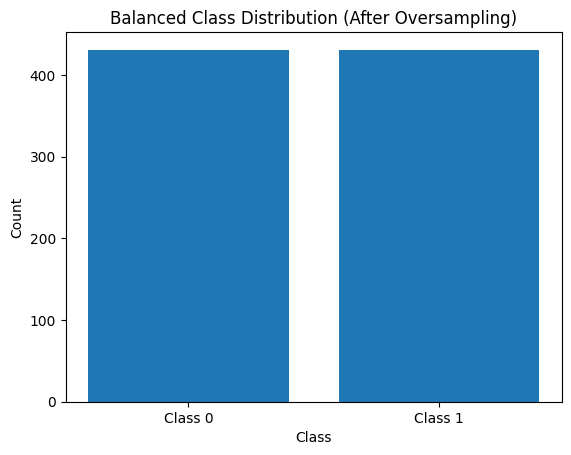

In [ ]:
 #Apply Oversampling to Training Set
train_labels = [full_dataset.targets[i] for i in train_idx]

ros = RandomOverSampler()
resampled_indices, _ = ros.fit_resample(
    np.array(train_idx).reshape(-1, 1), train_labels
)
resampled_indices = resampled_indices.flatten()

oversampled_train_data = Subset(full_dataset, resampled_indices)
oversampled_train_data.dataset.transform = train_transform
val_data.dataset.transform = val_transform

# Check balanced class distribution
balanced_labels = [full_dataset.targets[i] for i in resampled_indices]
balanced_dist = Counter(balanced_labels)
print("Balanced class distribution:", balanced_dist)

# Visualize balanced class distribution
plot_class_distribution(balanced_dist, "Balanced Class Distribution (After Oversampling)")



In [ ]:
train_loader = DataLoader(oversampled_train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)



In [ ]:
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    print(f"Batch image shape: {images.shape}")
    print(f"Batch labels: {labels}")
    break


Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')


In [ ]:
# Image transforms
image_size = 224
batch_size = 32

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load full dataset
full_dataset = datasets.ImageFolder(root=dataset_path)
print("Class to Index mapping:", full_dataset.class_to_idx)

# Get a manageable chunk
chunk_size = min(2000, len(full_dataset))  # Ensure chunk_size is not larger than dataset
subset_indices = np.random.choice(np.arange(len(full_dataset)), size=chunk_size, replace=False)
chunk_dataset = Subset(full_dataset, subset_indices)

Class to Index mapping: {'AiArtData': 0, 'RealArt': 1}


In [ ]:
def plot_class_distribution(counter_dict, title="Class Distribution"):
    classes = list(counter_dict.keys())
    counts = list(counter_dict.values())
    plt.bar(classes, counts, tick_label=[f"Class {i}" for i in classes])
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()


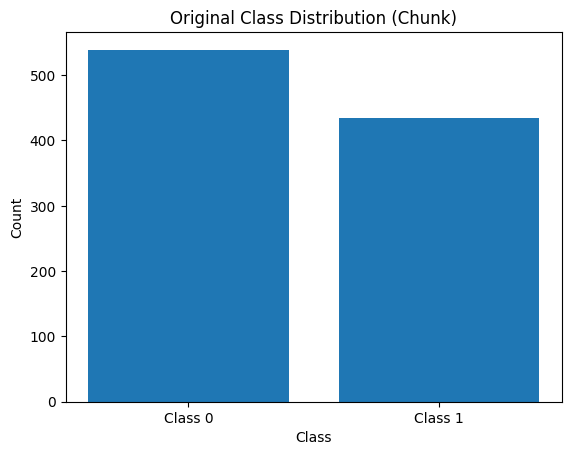

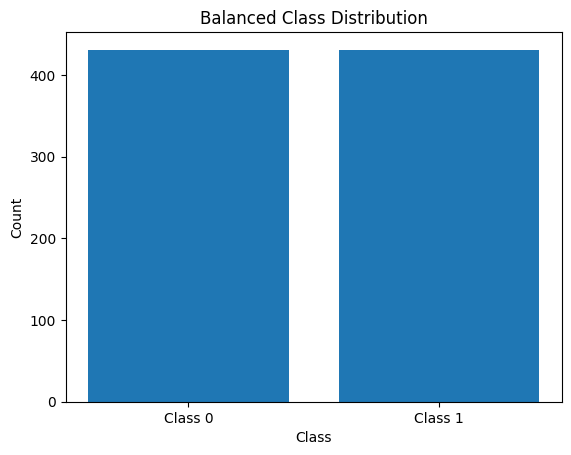

In [ ]:
# Get class distribution
targets = [full_dataset.targets[i] for i in subset_indices]
original_dist = Counter(targets)
plot_class_distribution(original_dist, "Original Class Distribution (Chunk)")

# Stratified split
train_idx, val_idx = train_test_split(
    subset_indices,
    test_size=0.2,
    stratify=targets,
    random_state=42
)
train_labels = [full_dataset.targets[i] for i in train_idx]

# Oversampling
ros = RandomOverSampler()
resampled_indices, _ = ros.fit_resample(np.array(train_idx).reshape(-1, 1), train_labels)
resampled_indices = resampled_indices.flatten()

# Final subsets
oversampled_train_data = Subset(full_dataset, resampled_indices)
val_data = Subset(full_dataset, val_idx)

oversampled_train_data.dataset.transform = train_transform
val_data.dataset.transform = val_transform

balanced_labels = [full_dataset.targets[i] for i in resampled_indices]
balanced_dist = Counter(balanced_labels)
plot_class_distribution(balanced_dist, "Balanced Class Distribution")

# Dataloaders
train_loader = DataLoader(oversampled_train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


TRAINING DATA MODELS

In [ ]:
model_accuracies = {}

def train_model(model, model_name, train_loader, val_loader, num_epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    best_acc = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                correct += (outputs.argmax(1) == labels).sum().item()
        val_acc = correct / len(val_loader.dataset)

        print(f"[{model_name}] Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Track best acc
        best_acc = max(best_acc, val_acc)

    model_accuracies[model_name] = best_acc


1. RESNET 18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)
train_model(resnet18, "ResNet18", train_loader, val_loader, num_epochs=5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[ResNet18] Epoch 1/5 - Train Acc: 0.7738, Val Acc: 0.8051
[ResNet18] Epoch 2/5 - Train Acc: 0.9838, Val Acc: 0.7846
[ResNet18] Epoch 3/5 - Train Acc: 0.9954, Val Acc: 0.8410
[ResNet18] Epoch 4/5 - Train Acc: 1.0000, Val Acc: 0.8256
[ResNet18] Epoch 5/5 - Train Acc: 1.0000, Val Acc: 0.8513


2. VGG16

In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 2)
train_model(vgg16, "VGG16", train_loader, val_loader, num_epochs=5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 63.5MB/s]


[VGG16] Epoch 1/5 - Train Acc: 0.6868, Val Acc: 0.8205
[VGG16] Epoch 2/5 - Train Acc: 0.8677, Val Acc: 0.8564
[VGG16] Epoch 3/5 - Train Acc: 0.9304, Val Acc: 0.7590
[VGG16] Epoch 4/5 - Train Acc: 0.9768, Val Acc: 0.7949
[VGG16] Epoch 5/5 - Train Acc: 0.9861, Val Acc: 0.8051


3. MOBILENET

In [ ]:
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 2)
train_model(mobilenet, "MobileNetV2", train_loader, val_loader, num_epochs=5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 104MB/s] 


[MobileNetV2] Epoch 1/5 - Train Acc: 0.7425, Val Acc: 0.8308
[MobileNetV2] Epoch 2/5 - Train Acc: 0.9095, Val Acc: 0.8564
[MobileNetV2] Epoch 3/5 - Train Acc: 0.9710, Val Acc: 0.8564
[MobileNetV2] Epoch 4/5 - Train Acc: 0.9919, Val Acc: 0.8615
[MobileNetV2] Epoch 5/5 - Train Acc: 0.9988, Val Acc: 0.8667


4. EFFICIENTNET

In [ ]:
efficientnet = models.efficientnet_b0(pretrained=True)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 2)
train_model(efficientnet, "EfficientNet_B0", train_loader, val_loader, num_epochs=5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 189MB/s]


[EfficientNet_B0] Epoch 1/5 - Train Acc: 0.6125, Val Acc: 0.7487
[EfficientNet_B0] Epoch 2/5 - Train Acc: 0.8631, Val Acc: 0.8154
[EfficientNet_B0] Epoch 3/5 - Train Acc: 0.9246, Val Acc: 0.8359
[EfficientNet_B0] Epoch 4/5 - Train Acc: 0.9571, Val Acc: 0.8410
[EfficientNet_B0] Epoch 5/5 - Train Acc: 0.9710, Val Acc: 0.8410


5. DENSENET

In [ ]:
densenet = models.densenet121(pretrained=True)
densenet.classifier = nn.Linear(densenet.classifier.in_features, 2)
train_model(densenet, "DenseNet121", train_loader, val_loader, num_epochs=5)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 135MB/s]


[DenseNet121] Epoch 1/5 - Train Acc: 0.7355, Val Acc: 0.8359
[DenseNet121] Epoch 2/5 - Train Acc: 0.9548, Val Acc: 0.8615
[DenseNet121] Epoch 3/5 - Train Acc: 0.9942, Val Acc: 0.8667
[DenseNet121] Epoch 4/5 - Train Acc: 0.9977, Val Acc: 0.8615
[DenseNet121] Epoch 5/5 - Train Acc: 0.9988, Val Acc: 0.8513


ACCURACY VISUALIZATION

In [ ]:
import plotly.graph_objects as go

def plot_model_accuracies_plotly(acc_dict):
    models = list(acc_dict.keys())
    accuracies = list(acc_dict.values())

    # Royal purple bars
    bar_color = '#4B0000'
    fig = go.Figure(data=[
        go.Bar(
            x=models,
            y=accuracies,
            marker_color=bar_color,
            text=[f"{acc*100:.2f}%" for acc in accuracies],
            textposition='inside',
            textfont=dict(color='white', size=14),
            hovertemplate='<b>%{x}</b><br>Accuracy: %{y:.2%}<extra></extra>'
        )
    ])

    fig.update_layout(
        title="Validation Accuracy of Deep Learning Models",
        xaxis_title="Model",
        yaxis_title="Accuracy",
        yaxis=dict(range=[0, 1], tickfont=dict(color='white'), titlefont=dict(color='white')),
        xaxis=dict(tickfont=dict(color='white'), titlefont=dict(color='white')),
        font=dict(size=16, color='white'),
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        uniformtext_minsize=12,
        uniformtext_mode='hide'
    )

    fig.show()
plot_model_accuracies_plotly(model_accuracies)


TESTING

FileUpload(value={}, accept='image/*', description='Upload')

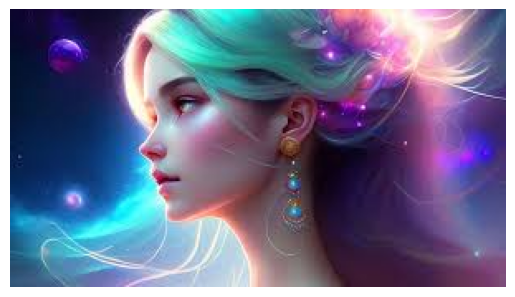


Predictions:

ResNet18 → Fake
VGG16 → Fake
MobileNetV2 → Fake
EfficientNet_B0 → Fake
DenseNet121 → Fake


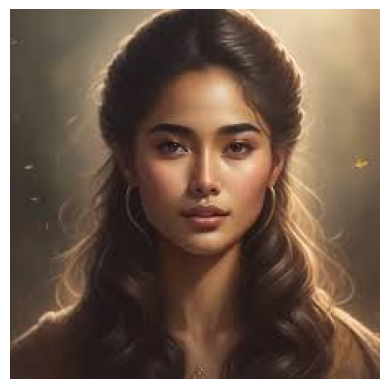


Predictions:

ResNet18 → Fake
VGG16 → Fake
MobileNetV2 → Fake
EfficientNet_B0 → Real
DenseNet121 → Fake


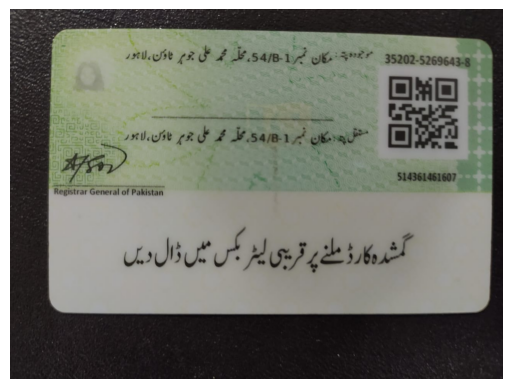


Predictions:

ResNet18 → Fake
VGG16 → Fake
MobileNetV2 → Fake
EfficientNet_B0 → Fake
DenseNet121 → Real


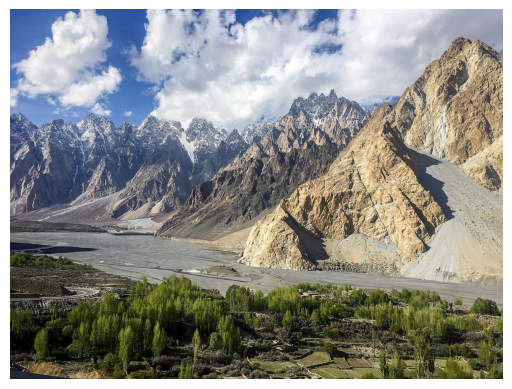


Predictions:

ResNet18 → Fake
VGG16 → Real
MobileNetV2 → Fake
EfficientNet_B0 → Real
DenseNet121 → Fake


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
from IPython.display import display, Image as IPImage
import matplotlib.pyplot as plt
# Device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_names = ['Fake', 'Real']

# Prediction function
def predict_image(uploaded_file):
    img = Image.open(uploaded_file).convert('RGB')
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    models_dict = {
        "ResNet18": resnet18.eval(),
        "VGG16": vgg16.eval(),
        "MobileNetV2": mobilenet.eval(),
        "EfficientNet_B0": efficientnet.eval(),
        "DenseNet121": densenet.eval()
    }

    predictions = {}
    for model_name, model in models_dict.items():
        with torch.no_grad():
            output = model(input_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            predictions[model_name] = class_names[predicted_class]

    return predictions

uploader = widgets.FileUpload(
    accept='image/*',  # Accept image files only
    multiple=False  # Single file upload
)

display(uploader)

def on_upload_change(change):
    if uploader.value:
        uploaded_file = list(uploader.value.values())[0]
        content = uploaded_file['content']
        from io import BytesIO
        image = BytesIO(content)

        # Display the image using PIL + matplotlib
        img = Image.open(image).convert("RGB")
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Reset the stream for model prediction
        image.seek(0)
        predictions = predict_image(image)

        print("\nPredictions:\n")
        for model_name, prediction in predictions.items():
            print(f"{model_name} → {prediction}")

uploader.observe(on_upload_change, names='value')

In [ ]:
!pip install sweetviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 114.8 MB/s eta 0:00:00


In [ ]:
!pip install shap opencv-python-headless


In [ ]:
import pandas as pd
dataset_path = kagglehub.dataset_download("cashbowman/ai-generated-images-vs-real-images")


densenet = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, 2)  # Assuming binary classifier
densenet.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet.to(device)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


class_names = ['Fake', 'Real']

# Dataset folder
dataset_path_contents = os.listdir(dataset_path)
print("Dataset folder contents:", dataset_path_contents)


image_paths = []
true_labels = []

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            image_paths.append(image_path)
            if 'real' in root.lower():
                true_labels.append('Real')
            elif 'ai' in root.lower() or 'fake' in root.lower():
                true_labels.append('Fake')


predicted_labels = []
for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = densenet(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        predicted_labels.append(class_names[predicted_class])

df_results = pd.DataFrame({
    'Image_Path': image_paths,
    'True_Label': true_labels,
    'Predicted_Label': predicted_labels
})

df_results['Correct'] = df_results['True_Label'] == df_results['Predicted_Label']
df_results.to_csv("denseNet_image_predictions.csv", index=False)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.



Dataset folder contents: ['RealArt', 'AiArtData']


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



In [ ]:
import sweetviz as sv
report = sv.analyze(df_results)
report.show_html("/content/denseNet_image_predictions.csv")

                                             |          | [  0%]   00:00 -> (? left)

Report /content/denseNet_image_predictions.csv was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



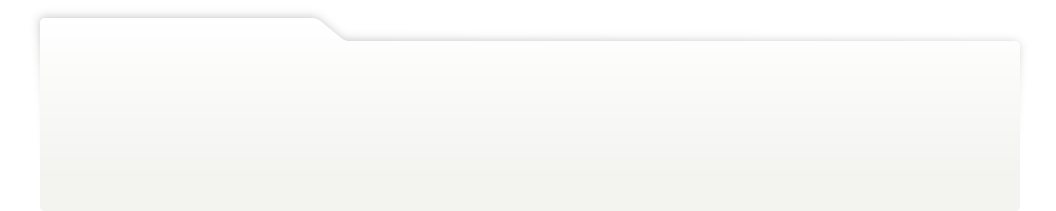
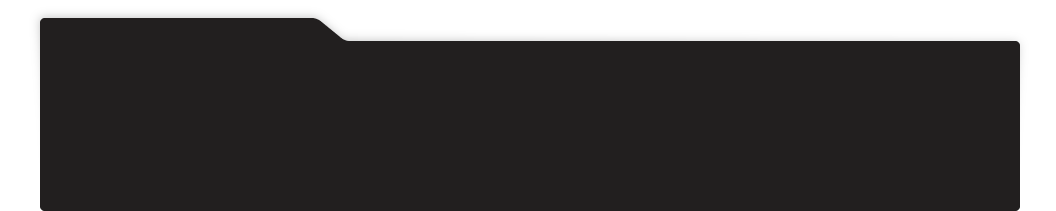
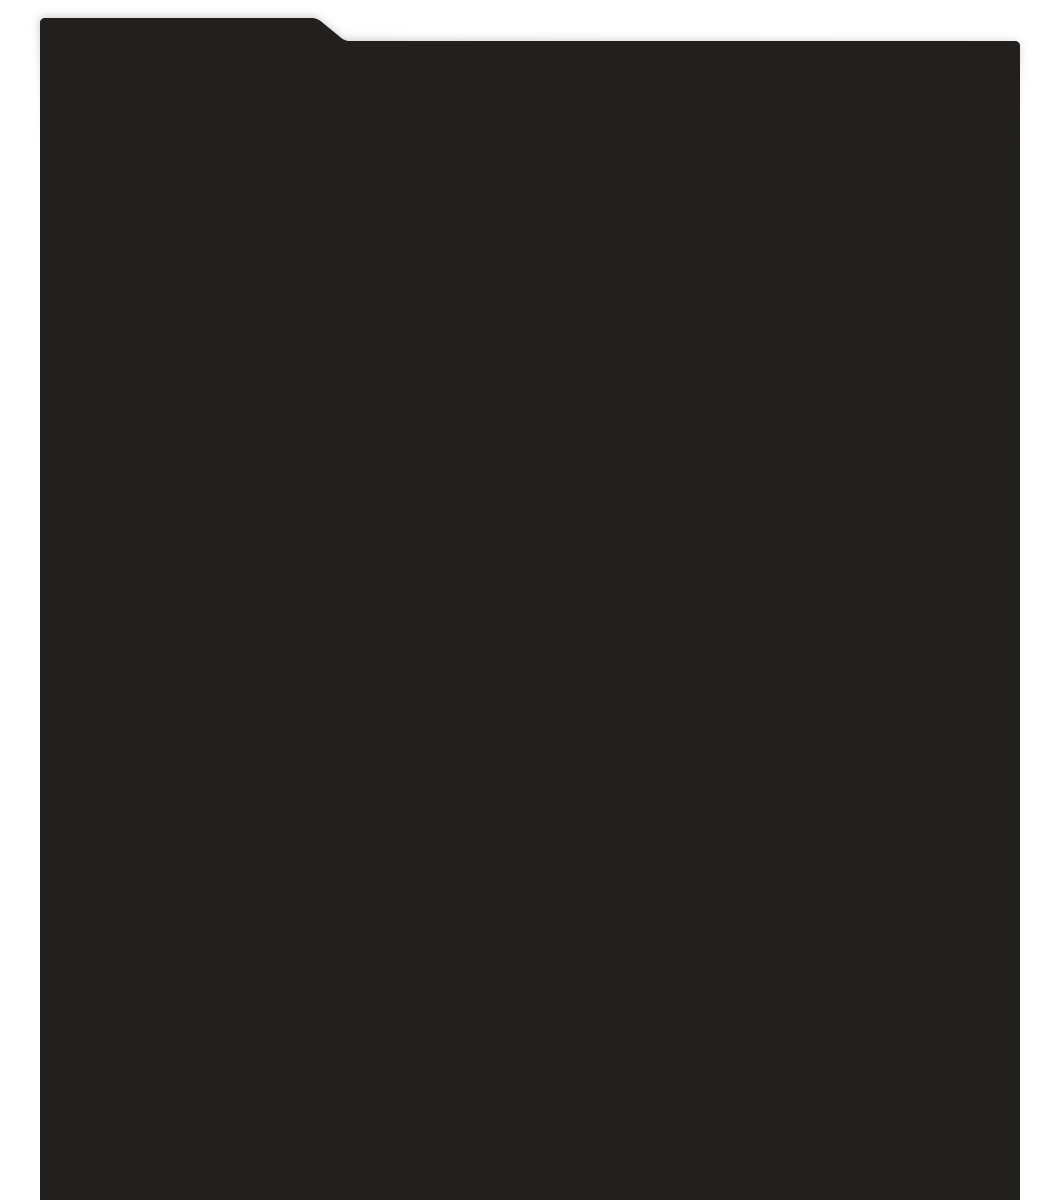
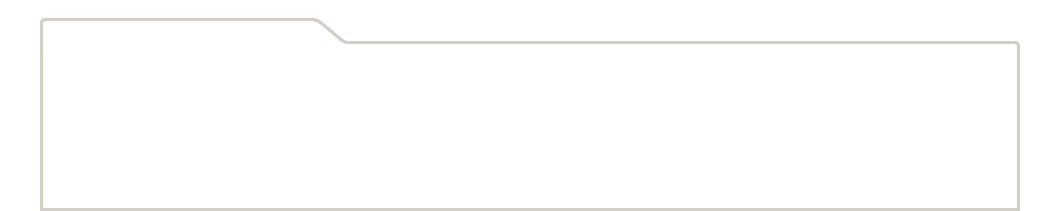
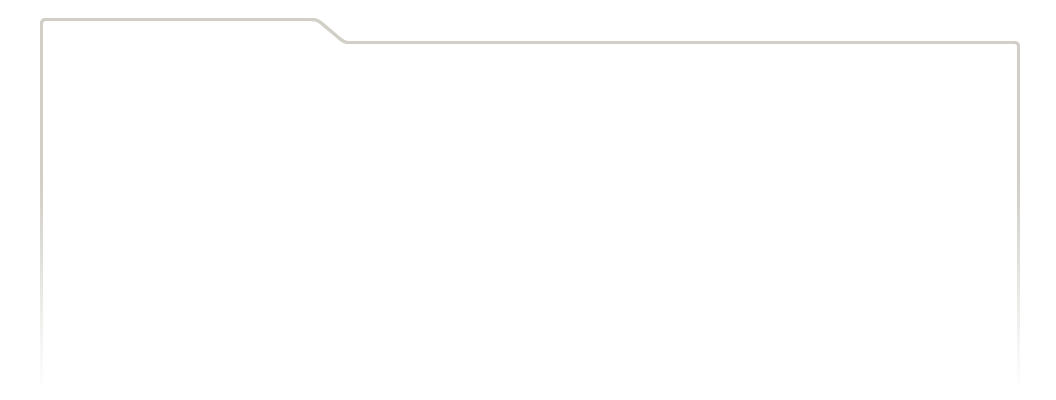
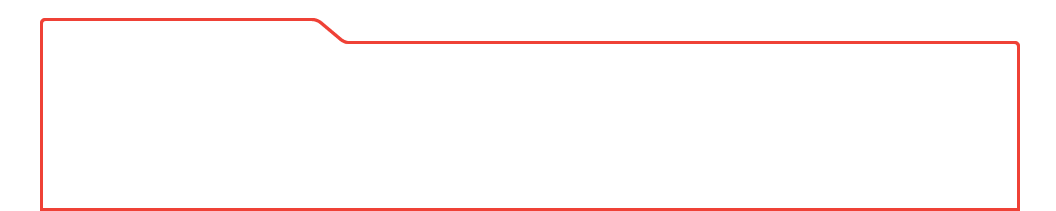
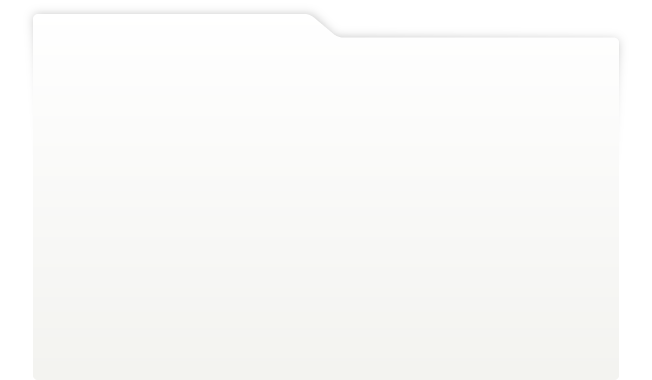
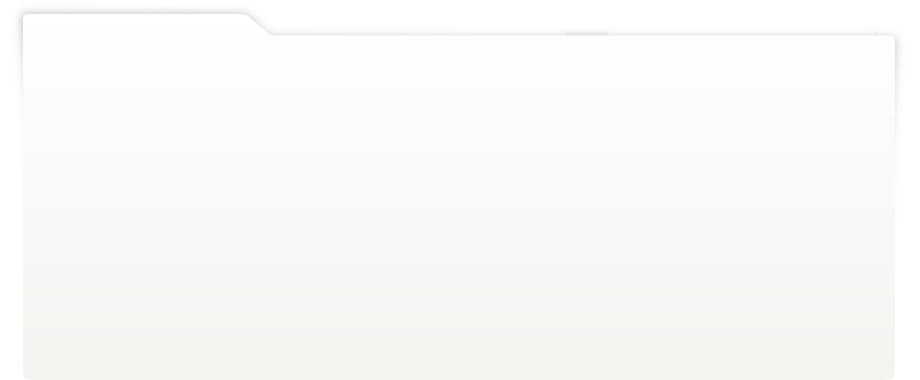
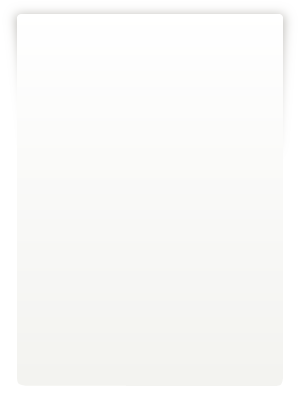
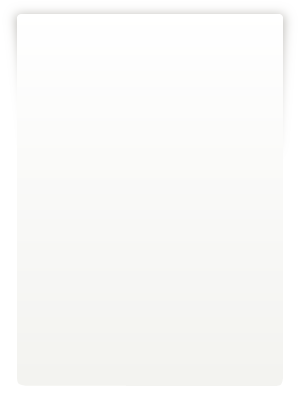
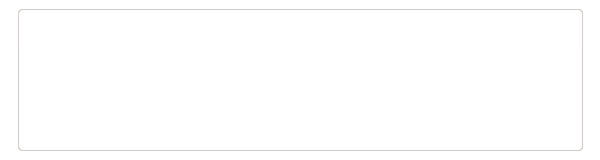
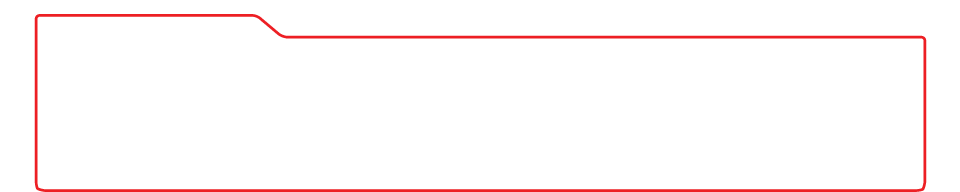
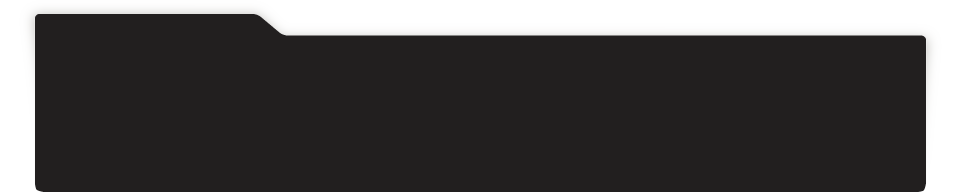
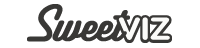
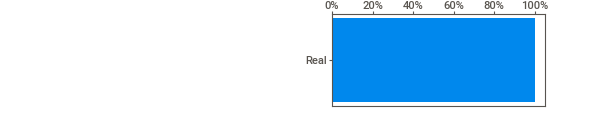
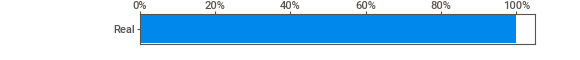
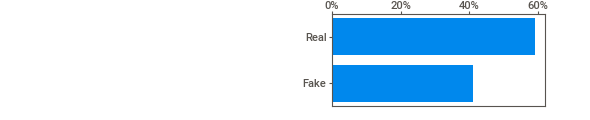
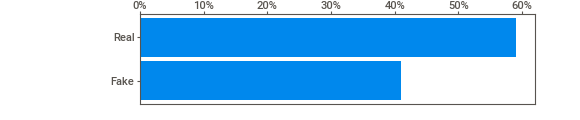
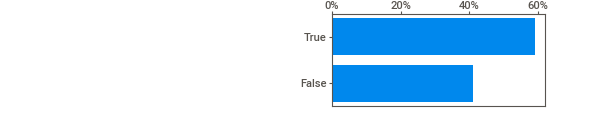
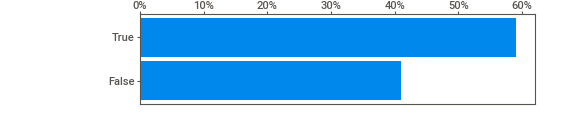
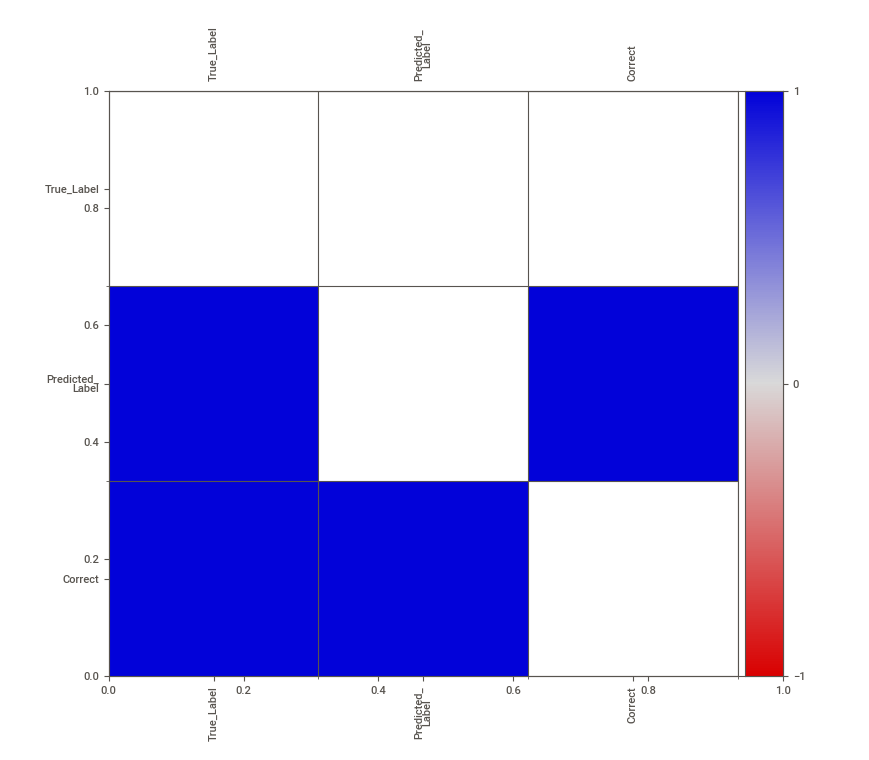
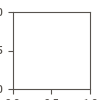

In [ ]:
report.show_notebook()

PROMPTS TO GENERATE CODE :

1. give me a code to load and visualize a KaggleHub image dataset, define data augmentation and normalization transforms, display class-to-index mapping, compute class distribution, and plot it using a bar chart

2. give me a code to perform a stratified train-validation split on an imbalanced image dataset, apply RandomOverSampler to balance the training set, visualize the class distributions before and after oversampling, and prepare PyTorch DataLoaders with defined image transformations for both training and validation datasets.

3. give me a code for a PyTorch training function that trains a model with Adam optimizer and CrossEntropyLoss, and tracks best validation accuracy.


 4. now give me code for these models Fine-tune pretrained models (ResNet18, VGG16, MobileNetV2, EfficientNet-B0, DenseNet121) by modifying their final layers for binary classification.

 5. Train each model on the given dataloaders and store their best validation accuracy in a dictionary.

 6. Create a Plotly bar chart to visualize validation accuracies of different models from a dictionary.
Customize the plot with royal purple bars, white text, dark background, and detailed hover info.
Display the chart showing model names on the x-axis and accuracy values on the y-axis.


 7. * Implement an image uploader and predictor that classifies an uploaded image as Real or Fake using five pretrained deep learning models.
    * Preprocess the uploaded image, display it, and generate predictions from all models with their respective labels.
    * Display predictions interactively upon image upload using IPython widgets and matplotlib visualization.

 8. Download and organize an image dataset of real vs AI-generated images, preprocess them, and predict labels using a fine-tuned DenseNet121 model.
Compare predicted labels with ground truth, save the classification results to a CSV file, and generate an exploratory data analysis report using Sweetviz.